In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, jaccard_similarity_score, roc_auc_score, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


path_parent = os.path.dirname(os.getcwd())
data_dir = os.path.join(path_parent,'data')
model_dir = os.path.join(path_parent,'models')
processed_dir = os.path.join(data_dir,'processed')
df_anomaly = pd.read_csv(os.path.join(processed_dir,"anomaly_anotated.csv"))
df_audsome = pd.read_csv(os.path.join(processed_dir,"anomaly_anotated_audsome.csv"))

In [70]:
print("Dataset chosen ...")
data = df_audsome
drop_col = ['t1','t2','t3','t4']
print("Remove unwanted columns ...")
print("Shape before drop: {}".format(data.shape))
data.drop(drop_col, axis=1, inplace=True)
print("Shape after drop: {}".format(data.shape))

Dataset chosen ...
Remove unwanted columns ...
Shape before drop: (3900, 67)
Shape after drop: (3900, 63)


In [71]:
# Nice print
nice_y = data['target']

# Uncomment for removing dummy
print("Removed Dummy class")
data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

Removed Dummy class


Ploting class distribution ..


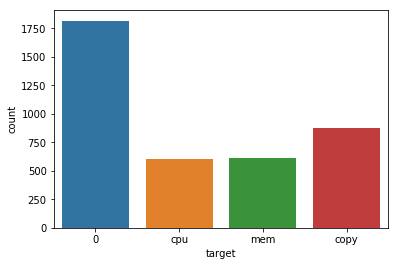

In [72]:
# Plot class distribution
print("Ploting class distribution ..")
sns.countplot(nice_y)

In [73]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


In [74]:
scaler = StandardScaler()

In [75]:
# Randomforest best performing

params =  {
    'n_estimators': 10,
    'max_depth': 50,
    'max_features': 50,
    'min_samples_split': 5,
    'min_samples_leaf': 11,
    'criterion': 'entropy',
    'random_state': 42}

clf = RandomForestClassifier(**params)
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features=50,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=11, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Starting fold 1
Scaling data ....
Start training ....
Predicting ....
----------------------------------------------------------------------------------------------------
Accuracy score fold 1 is: 0.9928205128205129
Ballanced accuracy fold 1 score is: 0.9938481497074696
Jaccard score fold 1: 0.9928205128205129
Full classification report for fold 1
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       454
         cpu       0.99      0.99      0.99       151
         mem       1.00      1.00      1.00       152
        copy       0.99      0.99      0.99       218

    accuracy                           0.99       975
   macro avg       0.99      0.99      0.99       975
weighted avg       0.99      0.99      0.99       975

Saving classification report
Generating confusion matrix fold 1
Extracting Feature improtance ...
####################################################################################################
Starting fold 2


/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classif

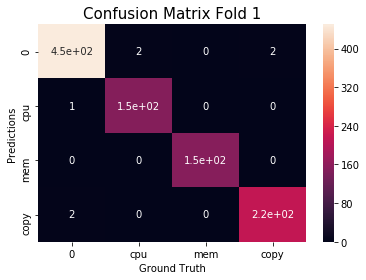

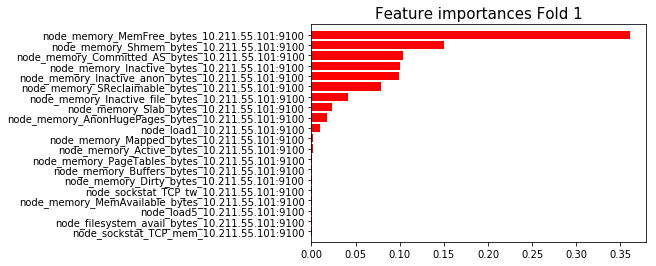

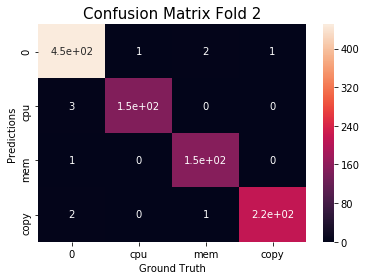

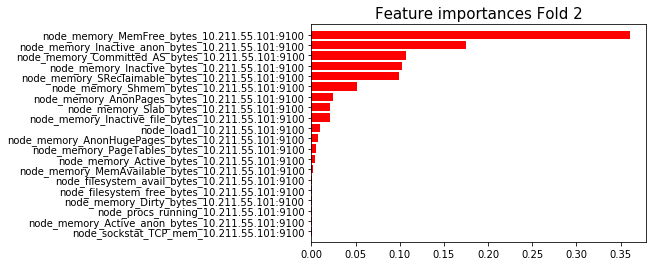

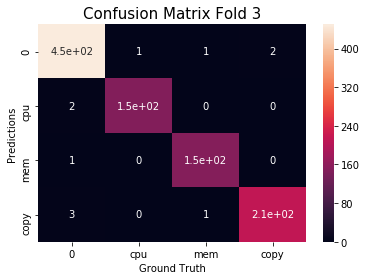

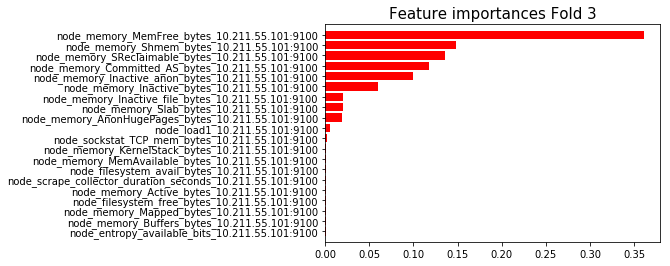

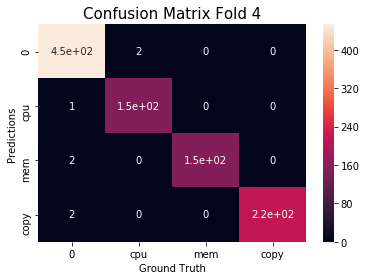

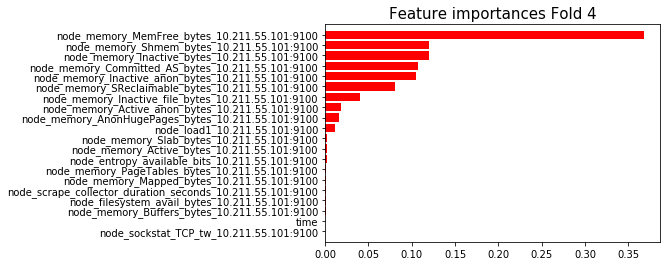

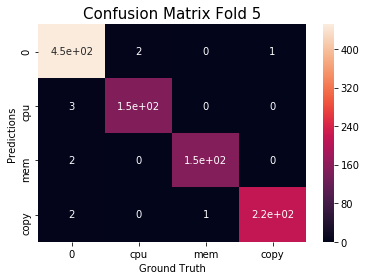

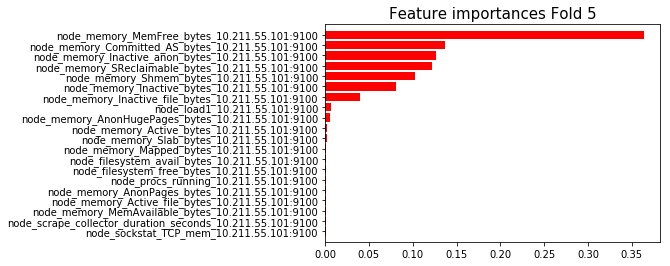

In [76]:
# skFold = StratifiedKFold(n_splits=5)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=21)
ml_method = 'rf'
print("="*100)
clf_models = []
report = {
    "Accuracy": [],
    "BallancedAccuracy": [],
    "Jaccard": []
}
fold = 1
for train_index, test_index in sss.split(X, y):
    # print("Train:", train_index, "Test:", test_index)
    print("Starting fold {}".format(fold))
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    print("Scaling data ....")
    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    print("Start training ....")
    clf.fit(Xtrain, ytrain)
    # Append model
    clf_models.append(clf)
    print("Predicting ....")
    ypred = clf.predict(Xtest)
    print("-"*100)
    acc = accuracy_score(ytest, ypred)
    report['Accuracy'].append(acc)
    print("Accuracy score fold {} is: {}".format(fold, acc))
    bacc = balanced_accuracy_score(ytest, ypred)
    report['BallancedAccuracy'].append(bacc)
    print("Ballanced accuracy fold {} score is: {}".format(fold, bacc))
    jaccard = jaccard_similarity_score(ytest, ypred)
    print("Jaccard score fold {}: {}".format(fold, jaccard))
    report['Jaccard'].append(jaccard)

    print("Full classification report for fold {}".format(fold))
    print(classification_report(ytest, ypred, digits=4,target_names=definitions))

    cf_report = classification_report(ytest, ypred, output_dict=True, digits=4, target_names=definitions)
    df_classification_report = pd.DataFrame(cf_report).transpose()
    print("Saving classification report")
    classification_rep_name = "classification_{}_fold_{}.csv".format(ml_method, fold)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)

    print("Generating confusion matrix fold {}".format(fold))
    cf_matrix = confusion_matrix(ytest, ypred)

    ht_cf=sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
    plt.title('Confusion Matrix Fold {}'.format(fold), fontsize = 15) # title with fontsize 20
    plt.xlabel('Ground Truth', fontsize = 10) # x-axis label with fontsize 15
    plt.ylabel('Predictions', fontsize = 10) # y-axis label with fontsize 15
    cf_fig = "CM_{}_{}.png".format(ml_method, fold)
    ht_cf.figure.savefig(os.path.join(model_dir, cf_fig))
    plt.show()


    print("Extracting Feature improtance ...")
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    sorted_feature = feat_importances.sort_values(ascending=True)
    # print(sorted_feature.head(-10))
    # print(type(sorted_feature.tail(15)))
    # print(X.shape[1])

    # Number of columns
    # print(len(sorted_feature))
    sorted_feature = sorted_feature.tail(20)
    # n_col = X.shape[1]
    n_col = len(sorted_feature)

    # Plot the feature importances of the forest

    plt.figure()
    plt.title("Feature importances Fold {}".format(fold), fontsize = 15)
    plt.barh(range(n_col), sorted_feature,
           color="r", align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(n_col), sorted_feature.index)
    plt.ylim([-1, n_col])
    fi_fig = "FI_{}_{}.png".format(ml_method, fold)
    plt.savefig(os.path.join(model_dir, fi_fig))
    plt.show()
    #increment fold count
    fold+=1
    print("#"*100)

In [77]:
print("Saving final report ...")
# Validation Report
df_report = pd.DataFrame(report)
final_report = "Model_{}_report.csv".format(ml_method)
df_report.to_csv(os.path.join(model_dir,final_report), index=False)

Saving final report ...
